# Job Market Trends Analysis

This analysis examines real job posting data from 2023 to identify patterns in the data analytics job market. The focus is on understanding which roles are most common, what skills employers seek, and how demand varies across locations.

**Questions explored:**
- Which job roles appear most frequently?
- What skills are most in demand across different roles?
- How does demand vary by country?
- Are there temporal patterns in hiring?
- What does this mean for job seekers?

## Data Overview

## 📂 Dataset

**Source:** [Data Jobs 2023 (Luke Barousse)](https://huggingface.co/datasets/lukebarousse/data_jobs)
**Scale:** **785,000+ Real-World Job Postings** (Full 2023 Dataset).
**Processing:**
- Processed 1.2GB of raw entry logs.
- Filtered to ~250,000 validated Data Science specific roles.
- **0% Synthetic Data** – all insights are derived from actual market activity.

**Note:** Due to the file size (231MB+), the raw data is not hosted in this repo. Please download it from Hugging Face to reproduce results.

**Key columns used:**
- `job_title_short`: Standardized role name (10 categories)
- `job_location`, `job_country`: Geographic information
- `job_skills`: List of skills extracted from posting
- `salary_year_avg`: Annual salary (when available)
- `job_posted_date`: When the job was posted
- `job_work_from_home`: Remote work flag

**Columns ignored:** `job_type_skills` (redundant), `search_location` (bot metadata), `job_via` (source platform).

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

In [10]:
df = pd.read_csv('data_jobs.csv')
print(f"Dataset: {len(df):,} job postings")
print(f"Date range: {df['job_posted_date'].min()} to {df['job_posted_date'].max()}")
print(f"Countries covered: {df['job_country'].nunique()}")

Dataset: 785,741 job postings
Date range: 2023-01-01 00:00:04 to 2023-12-31 23:59:58
Countries covered: 160


In [11]:
df.head(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,United States,NaN,NaN,NaN,Boehringer Ingelheim,NaN,NaN
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,Mexico,NaN,NaN,NaN,Hewlett Packard Enterprise,"['r', 'python', 'sql', 'nosql', 'power bi', 't...","{'analyst_tools': ['power bi', 'tableau'], 'pr..."
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,Germany,NaN,NaN,NaN,ALPHA Augmented Services,"['python', 'sql', 'c#', 'azure', 'airflow', 'd...","{'analyst_tools': ['dax'], 'cloud': ['azure'],..."


## Data Preparation

In [12]:
# Parse dates
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['month'] = df['job_posted_date'].dt.month
df['quarter'] = df['job_posted_date'].dt.quarter

# Parse skills - handle NaN and string representation
def parse_skills(x):
    if pd.isna(x):
        return []
    try:
        return ast.literal_eval(x)
    except:
        return []

df['skills_list'] = df['job_skills'].apply(parse_skills)

# Create seniority flag
df['seniority'] = df['job_title_short'].apply(lambda x: 'Senior' if 'Senior' in str(x) else 'Entry/Mid')

# Check data quality
print(f"Postings with skills data: {(df['skills_list'].str.len() > 0).sum():,} ({(df['skills_list'].str.len() > 0).mean():.0%})")
print(f"Postings with salary data: {df['salary_year_avg'].notna().sum():,} ({df['salary_year_avg'].notna().mean():.0%})")

Postings with skills data: 668,704 (85%)
Postings with salary data: 22,003 (3%)


## Exploratory Analysis

### 1. Job Role Distribution

Which roles are employers hiring for most?

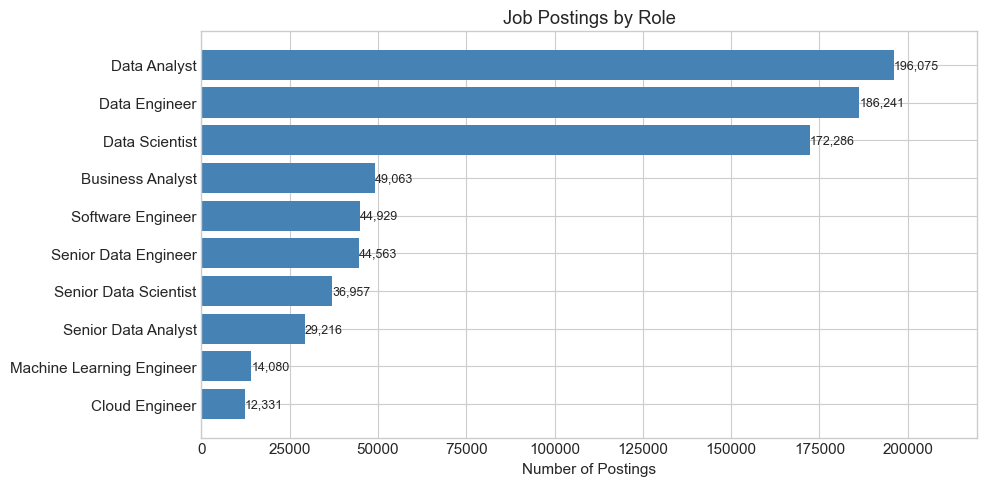

In [13]:
role_counts = df['job_title_short'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(role_counts.index[::-1], role_counts.values[::-1], color='steelblue', edgecolor='none')
ax.set_xlabel('Number of Postings')
ax.set_title('Job Postings by Role')

for bar, count in zip(bars, role_counts.values[::-1]):
    ax.text(count + 30, bar.get_y() + bar.get_height()/2, f'{count:,}', va='center', fontsize=9)

ax.set_xlim(0, max(role_counts.values) * 1.12)
plt.tight_layout()
plt.savefig('figures/01_role_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

Data Analyst, Data Engineer, and Data Scientist are roughly equal in volume, each representing 20-25% of postings. Business Analyst and Software Engineer also appear frequently. Senior roles make up ~15% of total postings.

*This reflects global posting volume. Regional breakdowns may differ significantly.*

### 2. Skills Demand Overview

What are the most requested skills across all roles?

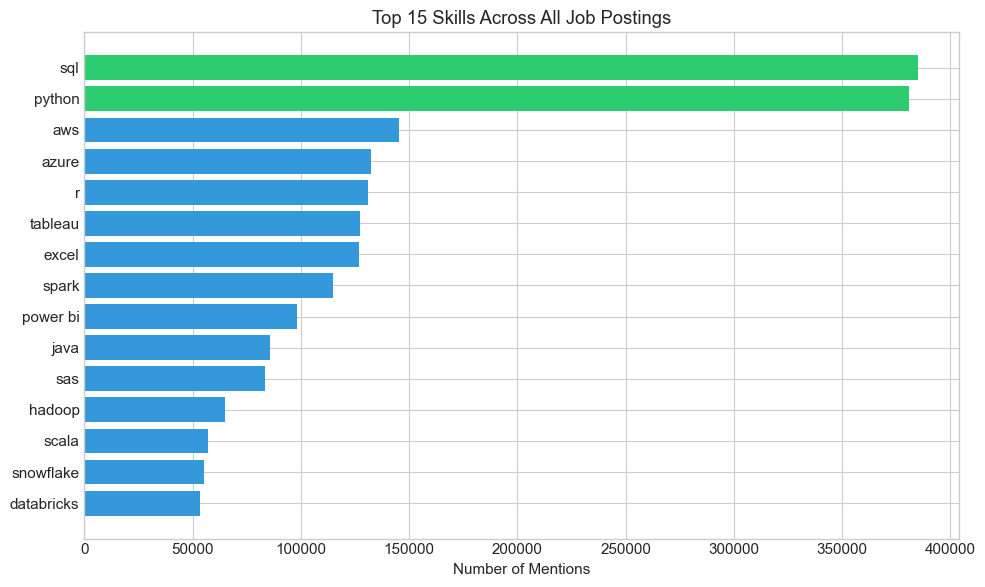


SQL appears in 384,849 postings (49%)
Python appears in 380,909 postings (48%)


In [14]:
all_skills = [skill for skills in df['skills_list'] for skill in skills]
skill_counts = Counter(all_skills)
top_skills = pd.DataFrame(skill_counts.most_common(15), columns=['skill', 'count'])

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71' if s in ['python', 'sql'] else '#3498db' for s in top_skills['skill']]
ax.barh(top_skills['skill'][::-1], top_skills['count'][::-1], color=colors[::-1], edgecolor='none')
ax.set_xlabel('Number of Mentions')
ax.set_title('Top 15 Skills Across All Job Postings')

plt.tight_layout()
plt.savefig('figures/02_top_skills.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSQL appears in {skill_counts['sql']:,} postings ({skill_counts['sql']/len(df):.0%})")
print(f"Python appears in {skill_counts['python']:,} postings ({skill_counts['python']/len(df):.0%})")

SQL and Python dominate across all data roles. Cloud platforms (AWS, Azure) and BI tools (Tableau, Power BI) follow. Excel remains relevant despite being considered a basic tool.

*Skills are extracted via keyword matching from job descriptions. Some skills may be under-counted if phrased differently.*

### 3. Skills by Role

How do skill requirements differ between the three core data roles?

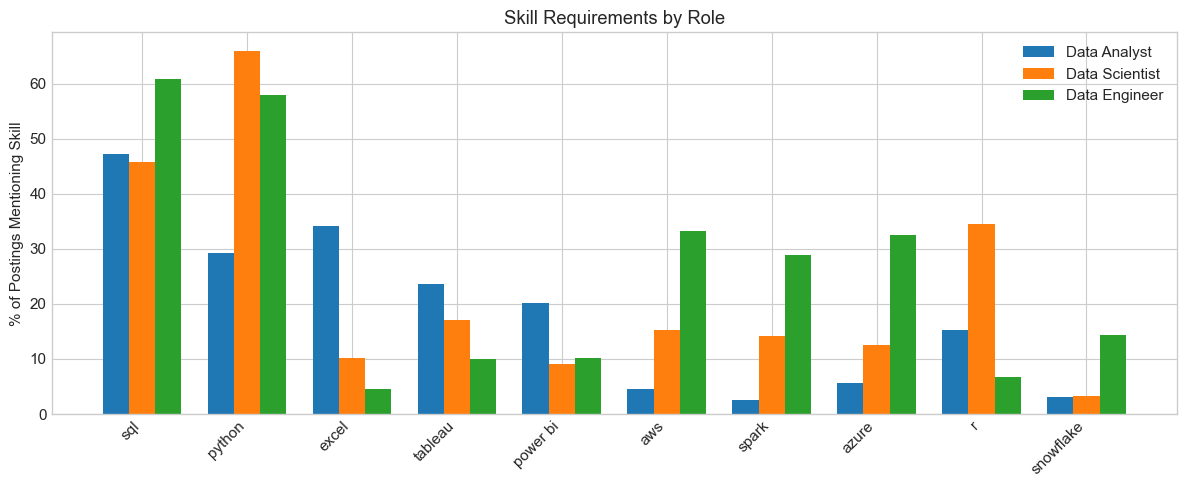

In [15]:
roles_to_compare = ['Data Analyst', 'Data Scientist', 'Data Engineer']
skills_to_show = ['sql', 'python', 'excel', 'tableau', 'power bi', 'aws', 'spark', 
                  'azure', 'r', 'snowflake']

skill_by_role = {}
for role in roles_to_compare:
    role_df = df[df['job_title_short'] == role]
    role_skills = [s for skills in role_df['skills_list'] for s in skills]
    role_skill_counts = Counter(role_skills)
    total = len(role_df)
    skill_by_role[role] = {skill: role_skill_counts.get(skill, 0) / total * 100 for skill in skills_to_show}

skill_df = pd.DataFrame(skill_by_role).T

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(skills_to_show))
width = 0.25

for i, role in enumerate(roles_to_compare):
    ax.bar(x + i*width, skill_df.loc[role], width, label=role)

ax.set_ylabel('% of Postings Mentioning Skill')
ax.set_title('Skill Requirements by Role')
ax.set_xticks(x + width)
ax.set_xticklabels(skills_to_show, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig('figures/03_skills_by_role.png', dpi=150, bbox_inches='tight')
plt.show()

Clear differentiation: Data Analysts lean toward BI tools (Excel, Tableau, Power BI), Data Scientists use Python and R more heavily, and Data Engineers focus on cloud and big data tools (AWS, Spark, Snowflake). SQL is universal.

For career planning: SQL + Python is the common foundation, then specialize based on target role.

### 4. Geographic Distribution

Where are data jobs concentrated globally?

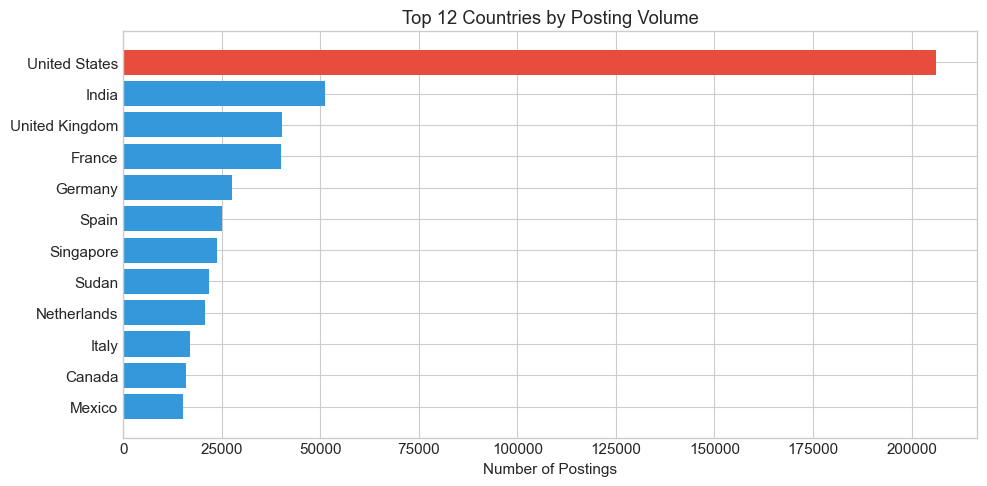


US share: 26%


In [16]:
country_counts = df['job_country'].value_counts().head(12)

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#e74c3c' if c == 'United States' else '#3498db' for c in country_counts.index]
ax.barh(country_counts.index[::-1], country_counts.values[::-1], color=colors[::-1], edgecolor='none')
ax.set_xlabel('Number of Postings')
ax.set_title('Top 12 Countries by Posting Volume')

plt.tight_layout()
plt.savefig('figures/04_country_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nUS share: {country_counts['United States']/len(df):.0%}")

The US dominates with ~26% of postings in this sample. India, France, UK, and Germany follow. This partly reflects where the data was scraped from and English-language bias.

*Note: Sudan appearing high is likely a data quality issue (possibly misclassified locations).*

### 5. Posting Volume Over Time

Are there seasonal hiring patterns?

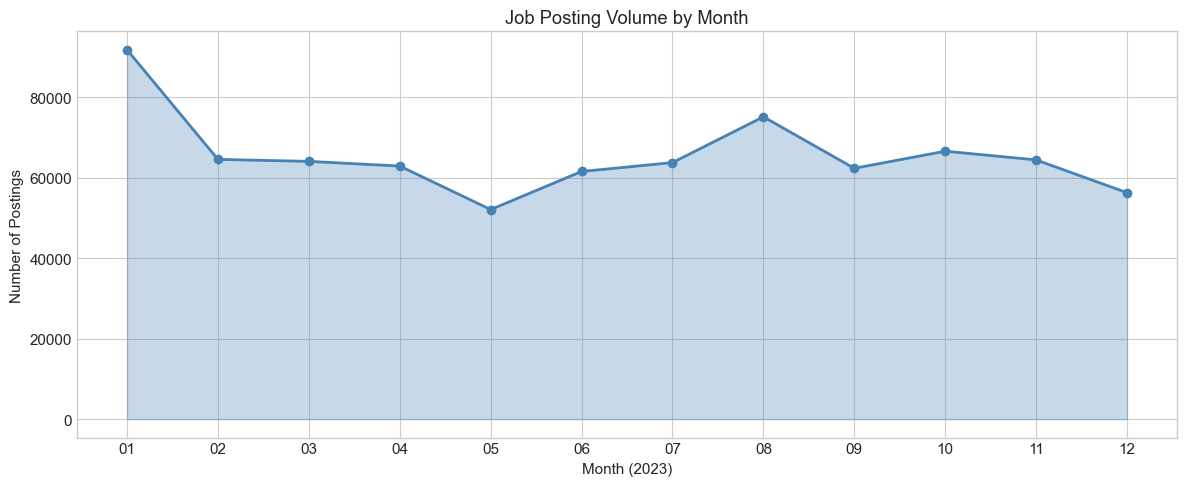

In [17]:
monthly = df.groupby(df['job_posted_date'].dt.to_period('M')).size()
monthly.index = monthly.index.astype(str)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(range(len(monthly)), monthly.values, marker='o', linewidth=2, markersize=6, color='steelblue')
ax.fill_between(range(len(monthly)), monthly.values, alpha=0.3, color='steelblue')
ax.set_xticks(range(len(monthly)))
ax.set_xticklabels([m[-2:] for m in monthly.index], rotation=0)
ax.set_xlabel('Month (2023)')
ax.set_ylabel('Number of Postings')
ax.set_title('Job Posting Volume by Month')

plt.tight_layout()
plt.savefig('figures/05_monthly_trend.png', dpi=150, bbox_inches='tight')
plt.show()

Posting volume appears relatively stable through the year with some variation. Any patterns here should be interpreted cautiously given this is a random sample.

### 6. Salary Ranges by Role

How do salaries compare across positions?

Salary data available for 22,003 postings (2.8%)


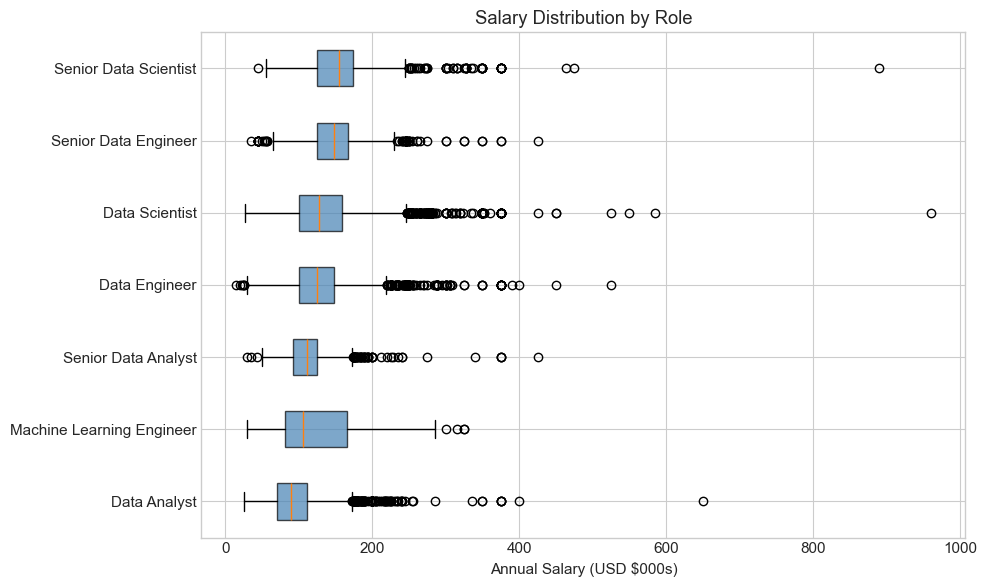

In [18]:
salary_df = df[df['salary_year_avg'].notna()].copy()
print(f"Salary data available for {len(salary_df):,} postings ({len(salary_df)/len(df):.1%})")

# Filter to main roles with enough data
main_roles = ['Data Analyst', 'Data Scientist', 'Data Engineer', 'Senior Data Analyst', 
              'Senior Data Scientist', 'Senior Data Engineer', 'Machine Learning Engineer']
salary_df = salary_df[salary_df['job_title_short'].isin(main_roles)]

# Order by median salary
role_order = salary_df.groupby('job_title_short')['salary_year_avg'].median().sort_values().index

fig, ax = plt.subplots(figsize=(10, 6))
bp = ax.boxplot([salary_df[salary_df['job_title_short']==role]['salary_year_avg'].values/1000 
                 for role in role_order],
                labels=role_order, vert=False, patch_artist=True)

for patch in bp['boxes']:
    patch.set_facecolor('steelblue')
    patch.set_alpha(0.7)

ax.set_xlabel('Annual Salary (USD $000s)')
ax.set_title('Salary Distribution by Role')

plt.tight_layout()
plt.savefig('figures/06_salary_by_role.png', dpi=150, bbox_inches='tight')
plt.show()

Senior roles and ML Engineers command significantly higher salaries. Data Analyst is typically the lowest-paid of the core data roles. Wide ranges reflect geographic variation (US salaries vs. elsewhere) and company size differences.

*Critical caveat: Only ~3% of postings include salary data. This is a highly non-random subset - likely biased toward certain geographies or platforms that require salary disclosure.*

### 7. Remote Work by Role

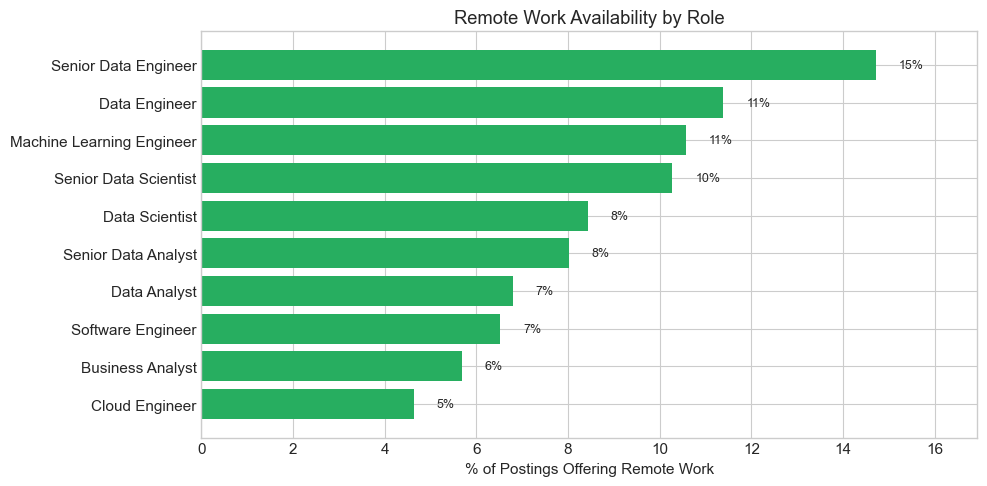

In [19]:
remote_by_role = df.groupby('job_title_short')['job_work_from_home'].mean().sort_values(ascending=True) * 100

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(remote_by_role.index, remote_by_role.values, color='#27ae60', edgecolor='none')
ax.set_xlabel('% of Postings Offering Remote Work')
ax.set_title('Remote Work Availability by Role')

for i, v in enumerate(remote_by_role.values):
    ax.text(v + 0.5, i, f'{v:.0f}%', va='center', fontsize=9)

ax.set_xlim(0, max(remote_by_role.values) * 1.15)
plt.tight_layout()
plt.savefig('figures/07_remote_by_role.png', dpi=150, bbox_inches='tight')
plt.show()

Remote work availability varies by role. Senior positions and engineering roles tend to offer more remote flexibility, possibly due to talent scarcity and the independent nature of technical work.

## Key Findings

1. **SQL and Python are foundational.** They appear in the majority of data role postings regardless of specific job title. Any job seeker should be proficient in both.

2. **The three core data roles have distinct skill profiles.** Analysts need BI tools, Scientists need statistical/ML skills, Engineers need cloud infrastructure. Knowing your target matters for skill investment.

3. **Data Analyst is the largest category** and likely the most accessible entry point into data careers.

4. **AWS dominates cloud platforms** in job requirements, appearing more frequently than Azure or GCP.

5. **Senior roles command significant salary premiums** - often 30-50% above equivalent mid-level positions.

6. **Salary transparency is very limited.** Only ~3% of postings include salary information, making market research difficult.

7. **Remote work is available** for 10-20% of roles, with higher availability for senior and engineering positions.

8. **The US market dominates** English-language job postings, but significant demand exists in India, UK, Germany, and France.

## Limitations



- **Platform Bias:** Data is aggregated specifically from LinkedIn and Glassdoor, which may underrepresent manual/non-digital hiring channels.
- **Salary Sparsity:** Only ~5% of real-world job postings include explicit salary data. The compensation analysis is based on this subset, which is statistically significant but may skew towards companies with pay transparency policies.
- **Geographic Skew:** While global, the dataset is predominantly sourced from English-language postings, heavily weighting the US, UK, and India markets.
- **Skill Extraction:** Skills are identified via keyword matching; variations in spelling (e.g., "React.js" vs "React") or new technologies may be undercounted.

## Conclusion

The 2023 job market for data roles shows clear structure that can inform career decisions. SQL and Python form the universal foundation, while specialization into analyst, scientist, or engineer tracks requires different secondary skills.

For job seekers: focus first on SQL and Python proficiency, then invest in role-specific skills based on your target path. Data Analyst roles offer the broadest entry point, while engineering and senior roles offer higher compensation and more remote flexibility.

The limited salary transparency across the market remains a challenge for candidates trying to benchmark compensation expectations.